In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
           'marital-status', 'occupation', 'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv('/Users/berkeelibol/anaconda_projects/3cd054a8-6e0f-4baf-88d9-78b83253cb18/adult.data', names=columns, na_values=' ?', skipinitialspace=True)
df = df.dropna()

# handles income by converting it, '<=50K' to 0 and '>50K' to 1
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

print(f"Data Shape after cleaning: {df.shape}")
print(df.head())

Data Shape after cleaning: (32561, 15)
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  income  
0          2174             0              40  United-States       0  
1

In [3]:
#Separate Features (X) and Target (y)
X = df.drop('income', axis=1)
y = df['income']

#Identify Categorical and Numerical Columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

#One-Hot Encoding for Categorical Variables
# This turns "workclass" into "workclass_Private", "workclass_Self-Emp", etc.
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

#Split the dataset (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalize (Scale) the Numerical Data
scaler = StandardScaler()

# Identify the indices of numerical columns in the new dataframe
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Data preparation complete.")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Data preparation complete.
Training set size: (26048, 100)
Test set size: (6513, 100)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the models and the parameters we want to tune

model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10]  
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 10, 20]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],  # no. of trees
            'max_depth': [10, 20, None]
        }
    }
}

# Loop through the models, tune them, and print results
best_models = {}

for name, mp in model_params.items():
    print(f"Training {name}...")
    
    # GridSearch tries every combination of parameters using 5-fold Cross-Validation
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Store the best model
    best_models[name] = clf.best_estimator_
    
    print(f"  Best Params: {clf.best_params_}")
    print(f"  Best CV Accuracy: {clf.best_score_:.4f}")
    print("-" * 30)

print("Tuning Complete!")

Training Logistic Regression...
  Best Params: {'C': 1}
  Best CV Accuracy: 0.8514
------------------------------
Training Decision Tree...
  Best Params: {'max_depth': 10, 'min_samples_split': 20}
  Best CV Accuracy: 0.8541
------------------------------
Training Random Forest...
  Best Params: {'max_depth': 20, 'n_estimators': 100}
  Best CV Accuracy: 0.8609
------------------------------
Tuning Complete!


=== Logistic Regression Evaluation ===
Test Accuracy: 0.8575
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4942
           1       0.75      0.61      0.67      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



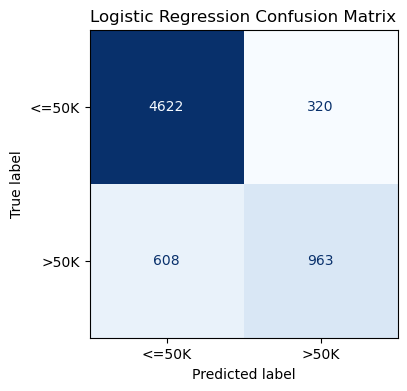



=== Decision Tree Evaluation ===
Test Accuracy: 0.8603
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4942
           1       0.77      0.60      0.67      1571

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



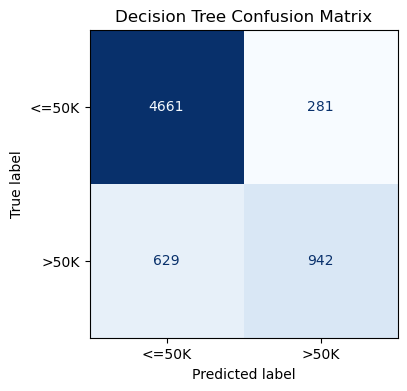



=== Random Forest Evaluation ===
Test Accuracy: 0.8673
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4942
           1       0.80      0.61      0.69      1571

    accuracy                           0.87      6513
   macro avg       0.84      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



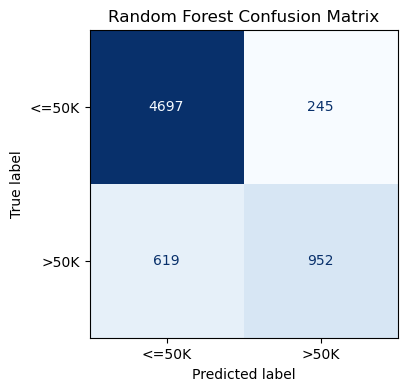

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compare models on the Test Set
for name, model in best_models.items():
    print(f"=== {name} Evaluation ===")
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
    
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    plt.show()
    print("\n" + "="*40 + "\n")